In [2]:
import pandas as pd
import numpy as np
import arviz as az

In [3]:
df_brazil = pd.read_excel(r'alldatasets.xlsx',sheet_name='Brazil')

In [4]:
df_brazil.head()

,childid,country,height,stunting_2cat,EDUYRS2,z_score,agegapr1,momeduyrsr1,chsexr1,agemonr1,hhsizer1,wi_newr1,job_cat,pvt_sector,earn_usd
0,BR0,Brazil,180.65,0.0,13.0,1.510429,7.0,8.0,1.0,47.0,4.0,0.882373,3.0,0.0,707.225360
1,BR1,Brazil,180.35,0.0,16.0,0.399053,0.0,5.0,1.0,50.0,3.0,0.306352,3.0,1.0,290.316010
2,BR2,Brazil,164.95,0.0,15.0,0.002132,NaN,5.0,0.0,52.0,3.0,0.533106,3.0,1.0,109.973544
3,BR3,Brazil,182.30,0.0,4.0,-1.823701,NaN,9.0,1.0,49.0,8.0,0.777917,NaN,NaN,0.000000
4,BR4,Brazil,NaN,NaN,NaN,NaN,NaN,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_brazil.columns

Index(['childid', 'country', 'height', 'stunting_2cat', 'EDUYRS2', 'z_score',
       'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1', 'hhsizer1',
       'wi_newr1', 'job_cat', 'pvt_sector', 'earn_usd'],
      dtype='object')

In [6]:
from scipy import stats
import scipy.stats as stats

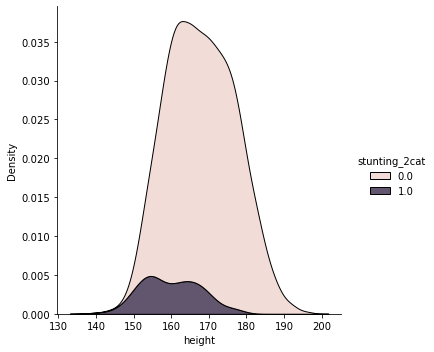

In [7]:
import seaborn as sns
sns.displot(df_brazil, x="height", hue="stunting_2cat", kind="kde", multiple="stack")

In [8]:
df_brazil=df_brazil.astype({"chsexr1": 'object', "job_cat": 'object', "pvt_sector": 'object',"stunting_2cat": 'object'})

In [9]:
df_outlier=df_brazil.copy()

In [10]:
total = df_outlier.isnull().sum().sort_values(ascending=False)
percent = (df_outlier.isnull().sum()/df_outlier.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 95]

,Total,Missing Percent


In [11]:
df_outlier=df_outlier.select_dtypes(include=['int64','floating'])

In [12]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
agegapr1       float64
momeduyrsr1    float64
agemonr1       float64
hhsizer1       float64
wi_newr1       float64
earn_usd       float64
dtype: object

In [13]:
import warnings

warnings.filterwarnings('ignore')

In [14]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
agegapr1       float64
momeduyrsr1    float64
agemonr1       float64
hhsizer1       float64
wi_newr1       float64
earn_usd       float64
dtype: object

In [15]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64') | ((df[col].dtype)=='float32')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df



In [16]:
final_df=cap_data(df_outlier)

capping the  height
capping the  EDUYRS2
capping the  z_score
capping the  agegapr1
capping the  momeduyrsr1
capping the  agemonr1
capping the  hhsizer1
capping the  wi_newr1
capping the  earn_usd


In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [18]:
df_brazil=df_brazil.drop(['childid','country'],axis=1)

In [19]:
all_category_features=df_brazil.select_dtypes(include='object')

In [20]:
all_category_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   stunting_2cat  4742 non-null   object
 1   chsexr1        5913 non-null   object
 2   job_cat        3017 non-null   object
 3   pvt_sector     2766 non-null   object
dtypes: object(4)
memory usage: 184.9+ KB


# KNN for Categories

In [21]:
mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [22]:
df_cat_imp=imputation(all_category_features,['stunting_2cat','chsexr1','job_cat','pvt_sector'])

In [23]:
df_cat_imp.isnull().sum().sort_values(ascending = False)

pvt_sector       0
job_cat          0
chsexr1          0
stunting_2cat    0
dtype: int64

In [24]:
df_cat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   stunting_2cat  5914 non-null   float64
 1   chsexr1        5914 non-null   float64
 2   job_cat        5914 non-null   float64
 3   pvt_sector     5914 non-null   float64
dtypes: float64(4)
memory usage: 184.9 KB


# KNN for numerics

In [25]:
df_knn=final_df.copy()

In [26]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_num_imp = pd.DataFrame(imputer.fit_transform(df_knn),columns = df_knn.columns)

In [27]:
df_num_imp.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd
0,180.65,13.0,1.510429,7.0,8.0,47.0,4.0,0.882373,707.225360
1,180.35,16.0,0.399053,0.0,5.0,50.0,3.0,0.306352,290.316010
2,164.95,15.0,0.002132,3.2,5.0,50.0,3.0,0.533106,109.973544
3,182.30,4.0,-1.823701,5.0,9.0,49.0,8.0,0.777917,0.000000
4,177.45,16.0,1.081756,6.2,15.0,45.6,3.6,0.677364,432.998727


In [28]:
df_outlier_concat = pd.concat([df_num_imp, df_cat_imp], axis=1)
df_outlier_concat.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,180.65,13.0,1.510429,7.0,8.0,47.0,4.0,0.882373,707.225360,0.0,1.0,3.0,0.0
1,180.35,16.0,0.399053,0.0,5.0,50.0,3.0,0.306352,290.316010,0.0,1.0,3.0,1.0
2,164.95,15.0,0.002132,3.2,5.0,50.0,3.0,0.533106,109.973544,0.0,0.0,3.0,1.0
3,182.30,4.0,-1.823701,5.0,9.0,49.0,8.0,0.777917,0.000000,0.0,1.0,2.0,1.0
4,177.45,16.0,1.081756,6.2,15.0,45.6,3.6,0.677364,432.998727,0.0,1.0,3.0,1.0


In [29]:
df_outlier_concat=df_outlier_concat.astype({"stunting_2cat": 'int64'})

In [30]:
df_outlier_concat.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,180.65,13.0,1.510429,7.0,8.0,47.0,4.0,0.882373,707.225360,0,1.0,3.0,0.0
1,180.35,16.0,0.399053,0.0,5.0,50.0,3.0,0.306352,290.316010,0,1.0,3.0,1.0
2,164.95,15.0,0.002132,3.2,5.0,50.0,3.0,0.533106,109.973544,0,0.0,3.0,1.0
3,182.30,4.0,-1.823701,5.0,9.0,49.0,8.0,0.777917,0.000000,0,1.0,2.0,1.0
4,177.45,16.0,1.081756,6.2,15.0,45.6,3.6,0.677364,432.998727,0,1.0,3.0,1.0


In [31]:
df_knn_imp=df_outlier_concat.copy()

# Bayesian

In [32]:
Y = df_knn_imp['height']
X = df_knn_imp[['stunting_2cat', 'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1','wi_newr1',
       'hhsizer1']]

In [33]:
import pymc3 as pm

with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 168.7, sd = 10)
    
    # Slope 
    stunting_2cat = pm.Normal('stunting_2cat', mu = 1, sd = 7.8)
    agemonr1        = pm.Normal('agemonr1', mu = 1, sd = 7.8)  
    chsexr1       = pm.Normal('chsexr1', mu = 1, sd = 7.8)  
    agegapr1        = pm.Normal('agegapr1', mu = 1, sd = 7.8)   
    momeduyrsr1     = pm.Normal('momeduyrsr1', mu = 1, sd = 7.8)  
    hhsizer1        = pm.Normal('hhsizer1', mu = 1, sd = 7.8)  
    wi_newr1        = pm.Normal('wi_newr1', mu = 1, sd = 7.8)
   
    
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + stunting_2cat * X.loc[:, 'stunting_2cat'] + agemonr1 * X.loc[:, 'agemonr1'] +     chsexr1 * X.loc[:, 'chsexr1'] +  agegapr1 * X.loc[:, 'agegapr1'] +  momeduyrsr1 * X.loc[:, 'momeduyrsr1']     +  hhsizer1 * X.loc[:, 'hhsizer1'] +  wi_newr1 * X.loc[:, 'wi_newr1'] 


    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y.values)
    
    # Sampler
    step = pm.NUTS(target_accept=0.95)

    # Posterior distribution
    linear_trace = pm.sample(16000, step)

KeyboardInterrupt: 

In [33]:
az.summary(linear_trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,161.177,1.069,159.161,163.196,0.006,0.004,33283.0,33282.0,33278.0,37973.0,1.0
stunting_2cat,-5.414,0.289,-5.944,-4.858,0.001,0.001,60413.0,60202.0,60425.0,47966.0,1.0
agemonr1,0.033,0.024,-0.011,0.078,0.000,0.000,34295.0,33359.0,34297.0,39188.0,1.0
chsexr1,7.855,0.159,7.561,8.160,0.001,0.000,62385.0,62370.0,62375.0,47560.0,1.0
agegapr1,-0.012,0.024,-0.058,0.033,0.000,0.000,54647.0,36981.0,54624.0,45312.0,1.0
momeduyrsr1,0.221,0.024,0.177,0.266,0.000,0.000,43778.0,43732.0,43786.0,44881.0,1.0
hhsizer1,-0.028,0.051,-0.123,0.068,0.000,0.000,51836.0,41482.0,51838.0,47528.0,1.0
wi_newr1,0.405,0.540,-0.615,1.413,0.003,0.002,41994.0,39430.0,41993.0,45087.0,1.0
sigma,6.118,0.056,6.012,6.224,0.000,0.000,54353.0,54337.0,54366.0,44299.0,1.0


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'stunting_2cat'}>,
        <AxesSubplot:title={'center':'stunting_2cat'}>],
       [<AxesSubplot:title={'center':'agemonr1'}>,
        <AxesSubplot:title={'center':'agemonr1'}>],
       [<AxesSubplot:title={'center':'chsexr1'}>,
        <AxesSubplot:title={'center':'chsexr1'}>],
       [<AxesSubplot:title={'center':'agegapr1'}>,
        <AxesSubplot:title={'center':'agegapr1'}>],
       [<AxesSubplot:title={'center':'momeduyrsr1'}>,
        <AxesSubplot:title={'center':'momeduyrsr1'}>],
       [<AxesSubplot:title={'center':'hhsizer1'}>,
        <AxesSubplot:title={'center':'hhsizer1'}>],
       [<AxesSubplot:title={'center':'wi_newr1'}>,
        <AxesSubplot:title={'center':'wi_newr1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

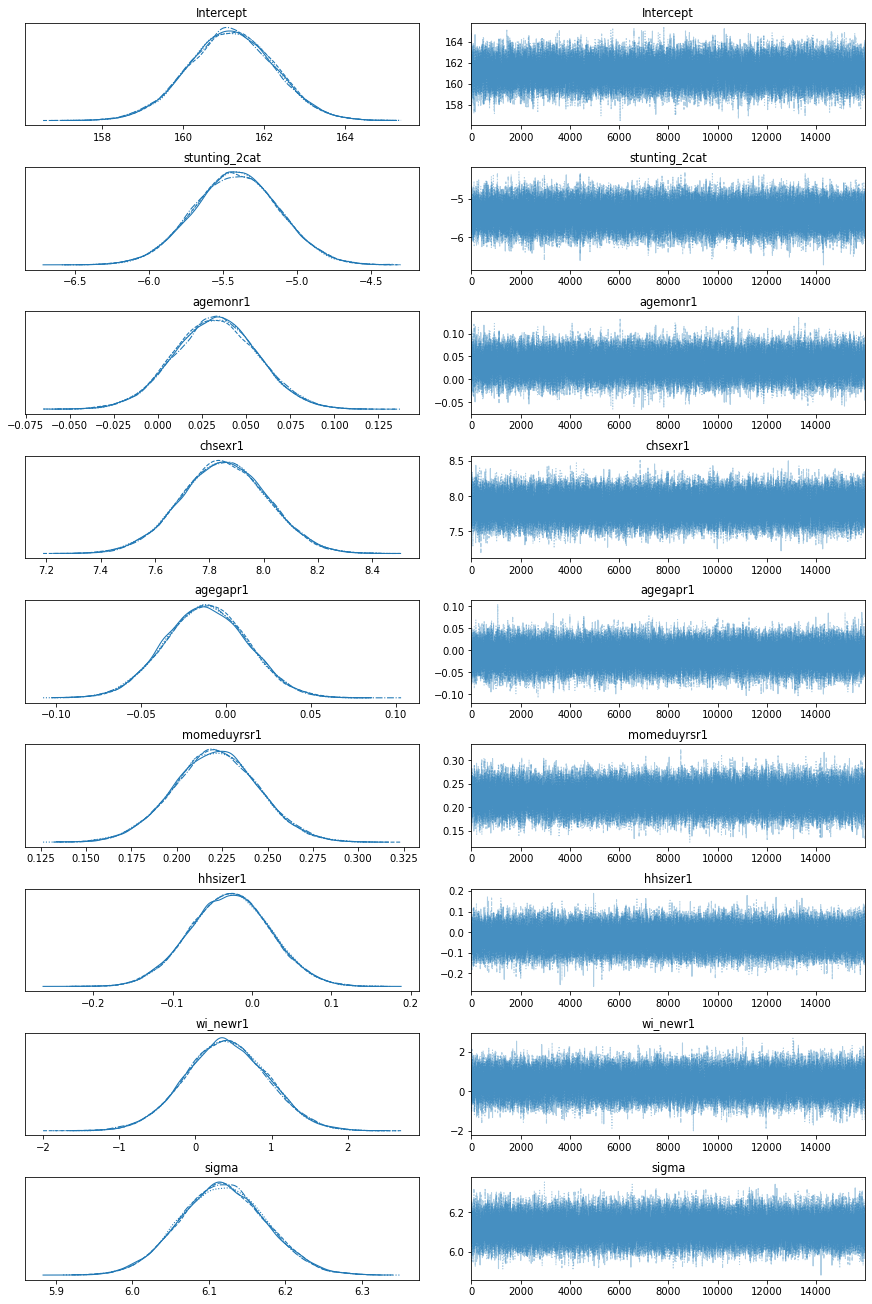

In [34]:
az.plot_trace(linear_trace)

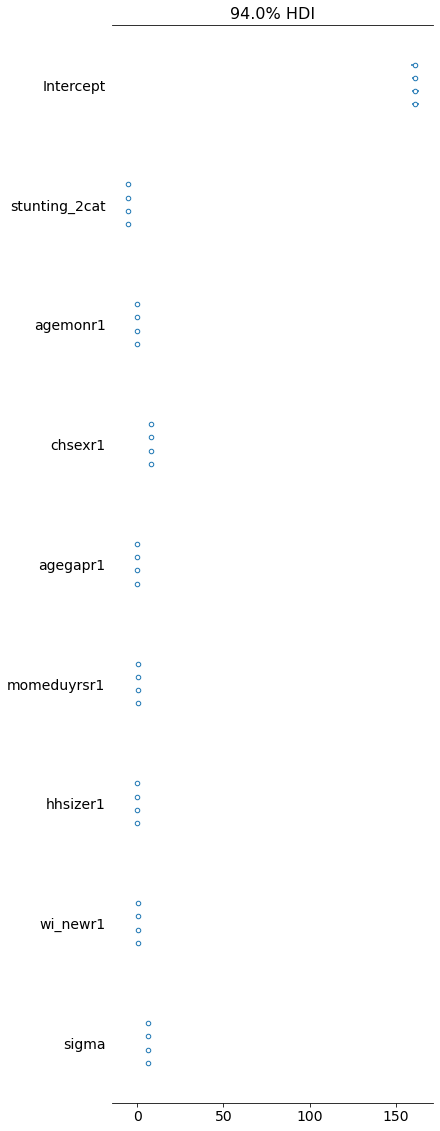

In [35]:
az.plot_forest(linear_trace);